In [1]:
import concurrent.futures
import json
import requests

from datetime import datetime
from pathlib import Path

import pandas as pd

from tqdm.notebook import tqdm
from urllib.parse import urlparse, parse_qs

In [2]:
storage = str(Path('~/Downloads').expanduser())

area_code = 'areaCode'
area_name = 'areaName'
area_type = 'areaType'
date = 'date'
new_cases_by_specimen_date = 'newCasesBySpecimenDate'
new_deaths_by_death_date = 'newDeathsByDeathDate'
release_timestamp = 'releaseTimestamp'

ltla = 'ltla'
nation = 'nation'

In [21]:
def get(filters, structure, **params):
    _params={
        'filters':';'.join(f'{k}={v}' for (k, v) in filters.items()),
        'structure': json.dumps({element:element for element in structure})
    }
    _params.update(params)
    response = requests.get('https://api.coronavirus-staging.data.gov.uk/v1/data', timeout=20, params=_params)
    if response.status_code != 200:
        raise ValueError(response.status_code)
    return response.json()

In [4]:
def pickle(name, df):
    for_dates = df[release_timestamp].unique()
    assert len(for_dates) == 1, for_dates
    for_date, = for_dates
    path = f'~/Downloads/phe_{name}_{for_date}_{datetime.now():%Y-%m-%d-%H-%M}.pickle'
    df.to_pickle(path)
    return path

In [10]:
def query(filters, structure, max_workers=None, **params):
    page = 1
    response = get(filters, structure, page=page, **params)
    result = response['data']
    max_page = int(parse_qs(urlparse(response['pagination']['last']).query)['page'][0])
    if max_page > 1:
        t = tqdm(total=max_page)
        t.update(1)
        todo = range(2, max_page+1)
        attempt = 0
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers or max_page-1) as executor:
            while todo:
                attempt += 1
                bad = []
                t.set_postfix({'errors': len(bad), 'attempt': attempt})
                futures = {executor.submit(get, filters, structure, page=page, **params): page 
                           for page in todo}
                for future in concurrent.futures.as_completed(futures):
                    page = futures[future]
                    try:
                        response = future.result()
                    except Exception as exc:
                        bad.append(page)
                        t.set_postfix({'errors': len(bad), 'attempt': attempt})
                    else:
                        result.extend(response['data'])
                        t.update(1)
                todo = bad
        t.close()
    return pd.DataFrame(result)

In [29]:
nation_data = query(
    filters={area_type: nation}, 
    structure=[release_timestamp, date, area_name, area_code, new_cases_by_specimen_date, new_deaths_by_death_date]
)
nation_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeathsByDeathDate
0,2020-07-19,2020-07-19,England,E92000001,NaN,NaN
1,2020-07-19,2020-07-19,Northern Ireland,N92000002,NaN,NaN
2,2020-07-19,2020-07-19,Scotland,S92000003,0.0,NaN
3,2020-07-19,2020-07-19,Wales,W92000004,NaN,NaN
4,2020-07-19,2020-07-18,England,E92000001,54.0,4.0
...,...,...,...,...,...,...
783,2020-07-19,2020-01-06,Wales,W92000004,NaN,NaN
784,2020-07-19,2020-01-05,England,E92000001,NaN,NaN
785,2020-07-19,2020-01-05,Northern Ireland,N92000002,NaN,NaN
786,2020-07-19,2020-01-05,Scotland,S92000003,NaN,NaN


In [30]:
pickle('nation', nation_data)

'~/Downloads/phe_nation_2020-07-19_2020-07-19-19-41.pickle'

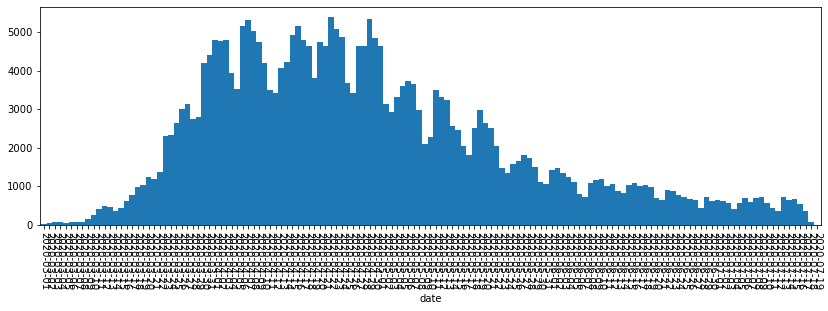

In [31]:
nation_data.groupby(date).sum()[new_cases_by_specimen_date].loc['2020-03-01':].plot(kind='bar', stacked=True, width=1, rot=-90, figsize=(14, 4))

In [33]:
area_data = query(
    filters={area_type: ltla}, 
    structure=[release_timestamp, date, area_name, area_code, new_cases_by_specimen_date, new_deaths_by_death_date],
    max_workers=10
)
area_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeathsByDeathDate
0,2020-07-19,2020-07-19,Aberdeen City,S12000033,NaN,None
1,2020-07-19,2020-07-19,Aberdeenshire,S12000034,NaN,None
2,2020-07-19,2020-07-19,Adur,E07000223,NaN,None
3,2020-07-19,2020-07-19,Allerdale,E07000026,NaN,None
4,2020-07-19,2020-07-19,Amber Valley,E07000032,NaN,None
...,...,...,...,...,...,...
72885,2020-07-19,2020-05-18,Carmarthenshire,W06000010,9.0,None
72886,2020-07-19,2020-05-18,Castle Point,E07000069,3.0,None
72887,2020-07-19,2020-05-18,Central Bedfordshire,E06000056,16.0,None
72888,2020-07-19,2020-05-18,Ceredigion,W06000008,0.0,None


In [35]:
pickle('area', area_data)

'~/Downloads/phe_area_2020-07-19_2020-07-20-08-57.pickle'